# Let's figure out which Boris Vishnevsky is real and which is not!

First and foremost import all the necessary data:

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from PIL import Image
import pickle
import time

##### Setting directory from which the images will be gathered. 
###### There are two folders which are representing two categories: Real Boris Lazarevich Vishnievsky and Not Vishnievsky

In [2]:
NAME = "BL_Vishnevsky_vs_others-{}".format(int(time.time()))

DATADIR = r"Your_dir\spot_the_real_Vishnevsky\img"
CATEGORIES = ['The Real Boris Lazarevich Vishnevsky', 'Not Vishnevsky']

Checking if the images are loading

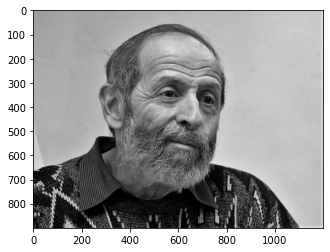

In [3]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

### Data augementation for both datasets:

In [5]:
# Folder with target images

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.15,
                        height_shift_range=0.1, shear_range=0.15,
                        zoom_range=0.12, channel_shift_range=10., horizontal_flip=True,
                        brightness_range=[0.3,0.9], fill_mode='nearest')

image_path = r'Your_dir\spot_the_real_Vishnevsky\img\The Real Boris Lazarevich Vishnevsky'
os.chdir(image_path)

j = 1
for img in os.listdir(image_path):
    im = Image.open(img)
    rgb_im = im.convert('RGB')
    rgb_im.save(img)
    j += 1


# Obtaining image
for img in os.listdir(image_path):
    image = io.imread(img, plugin='matplotlib')
    image = image.reshape((-1, ) + image.shape)

    i = 0
    for batch in gen.flow(image, batch_size=16,
                          save_to_dir=image_path,
                          save_prefix='aug',
                          save_format='jpg'):
        i += 1
        if i > 6:
            break

In [6]:
# Folder with images that program need to detect as not-target ones

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                        height_shift_range=0.15, shear_range=0.1,
                        zoom_range=0.1, channel_shift_range=10., horizontal_flip=True,
                        brightness_range=[0.3,0.9], fill_mode='nearest')

image_path = r'Your_dir\spot_the_real_Vishnevsky\img\Not Vishnevsky'
os.chdir(image_path)

j = 1
for img in os.listdir(image_path):
    im = Image.open(img)
    rgb_im = im.convert('RGB')
    rgb_im.save(img)
    j += 1


# Obtaining image
for img in os.listdir(image_path):
    #if img.endswith(".jpg"):
    image = io.imread(img, plugin='matplotlib')
    image = image.reshape((-1, ) + image.shape)

    i = 0
    for batch in gen.flow(image, batch_size=16,
                          save_to_dir=image_path,
                          save_prefix='aug',
                          save_format='jpg'):
        i += 1
        if i > 6:
            break

In [7]:
os.chdir(r'Your_dir\spot_the_real_Vishnevsky')
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

Current working directory: C:\Users\egoog\Documents\Coding\spot_the_real_Vishnevsky


To make model work we need to have images of the same size. At the same time we can define a specific person without color.
That is why cmap='gray'
Additionaly smaller sizes will let the model work faster. 
###### The picture is shown in order to check weather it is possible to identify a person visually or not.

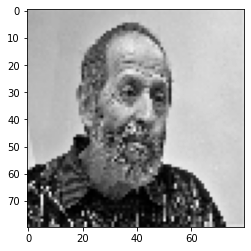

In [8]:
IMG_SIZE = 80

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [9]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                IMG_SIZE = 80
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

The size of the data is the following:

In [10]:
print(len(training_data))

1539


In [11]:
import random

random.shuffle(training_data)

In [12]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [13]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [14]:
pickle_in = open('X.pickle', 'rb')
X = pickle.load(pickle_in)

In [15]:
pickle_in = open('y.pickle', 'rb')
y = pickle.load(pickle_in)

In [16]:
X = X / 255.0

A neural network:

In [62]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape = X.shape[1:]))
model.add(layers.MaxPooling2D(3, 3))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten()) # this converts 3D feature matps into 1D feature labels

model.add(layers.Dense(64))
model.add(layers.Activation("relu"))

model.add(layers.Dense(1))
model.add(layers.Activation("sigmoid"))

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history = model.fit(X, y, batch_size=4, validation_split=0.3, epochs=5)

Epoch 1/5
270/270 [==============================] - 9s 33ms/step - loss: 0.7004 - accuracy: 0.5311 - val_loss: 0.6637 - val_accuracy: 0.5823
Epoch 2/5
270/270 [==============================] - 9s 33ms/step - loss: 0.6121 - accuracy: 0.6583 - val_loss: 0.5685 - val_accuracy: 0.6926
Epoch 3/5
270/270 [==============================] - 8s 30ms/step - loss: 0.4908 - accuracy: 0.7679 - val_loss: 0.5545 - val_accuracy: 0.7165
Epoch 4/5
270/270 [==============================] - 9s 32ms/step - loss: 0.3695 - accuracy: 0.8384 - val_loss: 0.5783 - val_accuracy: 0.7532
Epoch 5/5
270/270 [==============================] - 8s 31ms/step - loss: 0.2516 - accuracy: 0.9053 - val_loss: 0.5254 - val_accuracy: 0.7879


In [63]:
test_loss, test_acc = model.evaluate(X, y, verbose=2)
print('Accuracy is:', test_acc)

49/49 - 3s - loss: 0.2869 - accuracy: 0.8967
Accuracy is: 0.8966861367225647


The plot below shows quite good accuracy and quite low validation loss:

49/49 - 2s - loss: 0.2869 - accuracy: 0.8967


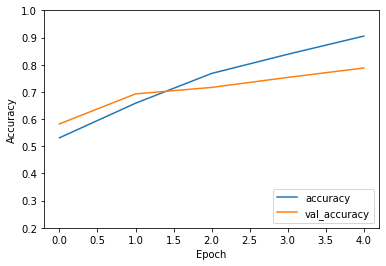

In [64]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X,  y, verbose=2)

49/49 - 2s - loss: 0.2869 - accuracy: 0.8967


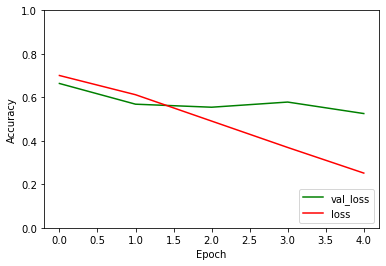

In [65]:
plt.plot(history.history['val_loss'], label = 'val_loss', color='green')
plt.plot(history.history['loss'], label = 'loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

test_loss, test_val_loss = model.evaluate(X,  y, verbose=2)

In [66]:
os.chdir(r'Your_dir\spot_the_real_Vishnevsky')
model.save('BLV-CNN.model')

INFO:tensorflow:Assets written to: BLV-CNN.model\assets
